In [ ]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d saisrushikgovindgari/nail-disease-dataset

nail-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/nail-disease-dataset.zip

Archive:  /content/nail-disease-dataset.zip
replace Nail Disease DataSet/Test/Darier_s disease/1.PNG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Nail Disease DataSet/Test/Darier_s disease/1.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/10.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/11.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/12.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/20.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/21.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/22.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/23.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/31.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/32.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/33.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/34.PNG  
  inflating: Nail Disease DataSet/Test/Darier_s disease/42.PNG  
  inflating: N

###Importimg Packages

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

##Preprocessing of Images

In [ ]:
train_path="/content/Nail Disease DataSet/Train"
test_path="/content/Nail Disease DataSet/Test"

In [ ]:
x_train=[]
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(255,255))
        x_train.append(img_arr)

In [ ]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(255,255))
        x_test.append(img_arr)

In [ ]:
train_x=np.array(x_train)
test_x=np.array(x_test)

train_x=train_x/255.0
test_x=test_x/255.0

###Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale =1./255,zoom_range=0.2,shear_range= 0.2,horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale =1./255)

In [ ]:
#Applying data augmentation for training data
training_set = train_datagen.flow_from_directory('/content/Nail Disease DataSet/Train',
                                            target_size=(255,255),
                                            class_mode = 'categorical',
                                            batch_size = 10)

Found 655 images belonging to 17 classes.


In [ ]:
#Applying data augmentation for testing data

test_set = test_datagen.flow_from_directory('/content/Nail Disease DataSet/Test',
                                            target_size=(255,255),
                                            class_mode = 'categorical',
                                            batch_size = 10)

Found 183 images belonging to 17 classes.


In [ ]:
train_y=training_set.classes
test_y=test_set.classes

In [ ]:
training_set.class_indices

{'Darier_s disease': 0,
 'Muehrck-e_s lines': 1,
 'aloperia areata': 2,
 'beau_s lines': 3,
 'bluish nail': 4,
 'clubbing': 5,
 'eczema': 6,
 'half and half nailes (Lindsay_s nails)': 7,
 'koilonychia': 8,
 'leukonychia': 9,
 'onycholycis': 10,
 'pale nail': 11,
 'red lunula': 12,
 'splinter hemmorrage': 13,
 'terry_s nail': 14,
 'white nail': 15,
 'yellow nails': 16}

In [ ]:
train_y.shape,test_y.shape

((655,), (183,))

##Model Building using Transfer Learning

####VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
vgg19=VGG19(input_shape=[255,255]+[3],weights='imagenet',include_top=False)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
for layer in vgg19.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg19.output)

In [ ]:
output = Dense(17,activation='softmax')(x)

In [ ]:
vgg=Model(vgg19.input,output)

In [ ]:
vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 255, 255, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 255, 255, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0   

In [ ]:
vgg.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics =['accuracy','mse'],
              run_eagerly=True)

In [ ]:
#Early stopping to avoid overfitting of model
from tensorflow.keras.callbacks import EarlyStopping

early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)


In [ ]:
history = vgg.fit(train_x,train_y,
                  validation_data=(test_x,test_y),
                  epochs=17,
                  batch_size=7,
                  steps_per_epoch=(len(training_set))
              )

Epoch 1/17
66/66 [==============================] - 24s 288ms/step - loss: 0.7212 - accuracy: 0.8355 - mse: 76.1085 - val_loss: 6.2284 - val_accuracy: 0.3661 - val_mse: 75.6588
Epoch 2/17
66/66 [==============================] - 22s 338ms/step - loss: 1.4138 - accuracy: 0.7190 - mse: 79.6370 - val_loss: 5.8675 - val_accuracy: 0.4536 - val_mse: 75.6606
Epoch 3/17
66/66 [==============================] - 19s 284ms/step - loss: 0.8366 - accuracy: 0.7865 - mse: 75.7627 - val_loss: 6.0214 - val_accuracy: 0.4918 - val_mse: 75.6633
Epoch 4/17
66/66 [==============================] - 18s 279ms/step - loss: 0.9108 - accuracy: 0.7814 - mse: 79.3827 - val_loss: 6.5942 - val_accuracy: 0.3497 - val_mse: 75.6609
Epoch 5/17
66/66 [==============================] - 18s 280ms/step - loss: 0.5065 - accuracy: 0.8584 - mse: 71.8999 - val_loss: 6.4433 - val_accuracy: 0.5191 - val_mse: 75.6642
Epoch 6/17
66/66 [==============================] - 18s 280ms/step - loss: 0.4381 - accuracy: 0.8932 - mse: 80.4239

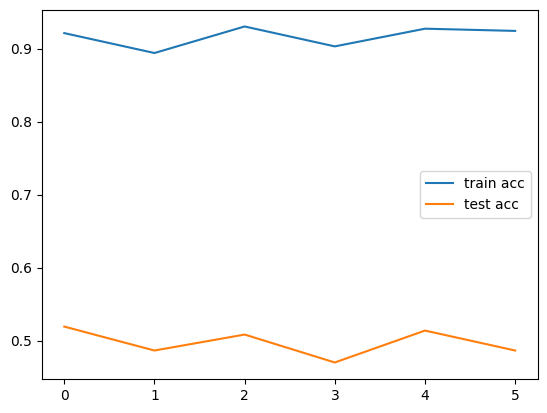

In [ ]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='test acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()


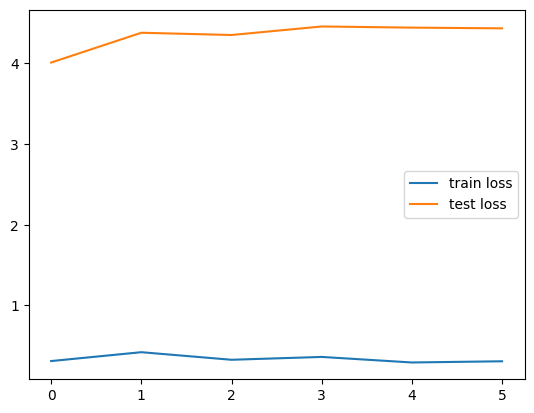

In [ ]:
# loss

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()


##Performance Metrics

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np
#predict
y_pred=vgg.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)


6/6 [==============================] - 1s 234ms/step


In [ ]:
vgg.evaluate(test_x,test_y)

6/6 [==============================] - 2s 298ms/step - loss: 7.8457 - accuracy: 0.4973 - mse: 75.6648


[7.845677852630615, 0.4972677528858185, 75.66478729248047]

In [ ]:
#get accuracy score
print(accuracy_score(y_pred,test_y))

0.48633879781420764


In [ ]:
#get classification report
print(classification_report(y_pred,test_y))


              precision    recall  f1-score   support

           0       0.71      0.75      0.73        16
           1       0.22      0.18      0.20        11
           2       0.33      0.62      0.43         8
           3       0.62      0.31      0.42        16
           4       0.23      0.21      0.22        14
           5       0.25      0.38      0.30         8
           6       0.58      0.54      0.56        13
           7       0.60      0.69      0.64        13
           8       0.75      0.75      0.75         8
           9       0.83      0.71      0.77         7
          10       0.50      0.86      0.63         7
          11       0.38      0.33      0.35         9
          12       0.27      0.44      0.33         9
          13       0.50      0.31      0.38        16
          14       0.67      0.55      0.60        11
          15       0.83      0.62      0.71         8
          16       1.00      0.89      0.94         9

    accuracy              

Axes(0.125,0.11;0.62x0.77)


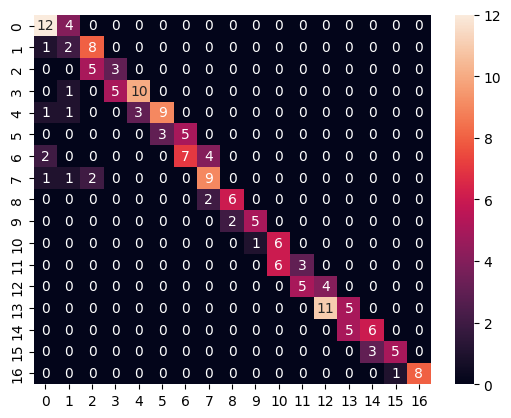

In [ ]:
import seaborn as sns
#get confusion matrix
print(sns.heatmap(confusion_matrix(y_pred,test_y),annot=True))

In [ ]:
vgg.save('vgg-16-nail-disease.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

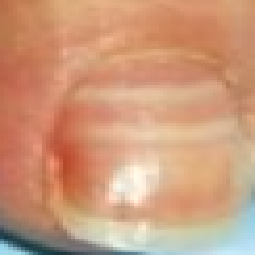

In [ ]:
img=image.load_img('/content/Nail Disease DataSet/Train/Muehrck-e_s lines/10.PNG', target_size=(255,255))
img

In [ ]:
resized_image = tf.reshape(img, (255, 255, 3))
resized_image = tf.squeeze(resized_image)
resized_image

<tf.Tensor: shape=(255, 255, 3), dtype=uint8, numpy=
array([[[182, 108,  73],
        [182, 108,  73],
        [182, 108,  73],
        ...,
        [203, 148, 107],
        [203, 148, 107],
        [203, 148, 107]],

       [[182, 108,  73],
        [182, 108,  73],
        [182, 108,  73],
        ...,
        [203, 148, 107],
        [203, 148, 107],
        [203, 148, 107]],

       [[182, 108,  73],
        [182, 108,  73],
        [182, 108,  73],
        ...,
        [203, 148, 107],
        [203, 148, 107],
        [203, 148, 107]],

       ...,

       [[163, 217, 236],
        [163, 217, 236],
        [163, 217, 236],
        ...,
        [197, 232, 247],
        [197, 232, 247],
        [197, 232, 247]],

       [[163, 217, 236],
        [163, 217, 236],
        [163, 217, 236],
        ...,
        [197, 232, 247],
        [197, 232, 247],
        [197, 232, 247]],

       [[163, 217, 236],
        [163, 217, 236],
        [163, 217, 236],
        ...,
        [197, 232, 24

In [ ]:
x = image.img_to_array(resized_image)
x = np.expand_dims(x,axis = 0)
x

array([[[[182., 108.,  73.],
         [182., 108.,  73.],
         [182., 108.,  73.],
         ...,
         [203., 148., 107.],
         [203., 148., 107.],
         [203., 148., 107.]],

        [[182., 108.,  73.],
         [182., 108.,  73.],
         [182., 108.,  73.],
         ...,
         [203., 148., 107.],
         [203., 148., 107.],
         [203., 148., 107.]],

        [[182., 108.,  73.],
         [182., 108.,  73.],
         [182., 108.,  73.],
         ...,
         [203., 148., 107.],
         [203., 148., 107.],
         [203., 148., 107.]],

        ...,

        [[163., 217., 236.],
         [163., 217., 236.],
         [163., 217., 236.],
         ...,
         [197., 232., 247.],
         [197., 232., 247.],
         [197., 232., 247.]],

        [[163., 217., 236.],
         [163., 217., 236.],
         [163., 217., 236.],
         ...,
         [197., 232., 247.],
         [197., 232., 247.],
         [197., 232., 247.]],

        [[163., 217., 236.],
       

In [ ]:
pred =np.argmax(vgg.predict(x),axis=1)
op =['Darier_s disease','Muehrck-e_s lines','aloperia areata','beau_s lines',
     'bluish nail','clubbing','eczema','half and half nailes (Lindsay_s nails)',
     'koilonychia','leukonychia','onycholycis','pale nail','red lunula',
     'splinter hemmorrage','terry_s nail','white nail','yellow nails']
result = str(op[pred[0]])
result

1/1 [==============================] - 1s 1s/step


'leukonychia'